# **LSTM-Based Time Series Prediction for Fuel Consumption in Guatemala** 📊 

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Etiam ultrices, dui id viverra ornare, massa leo egestas ipsum, quis tempus sapien lorem sed odio. In non tempor magna. Vestibulum purus magna, pellentesque quis mattis a, interdum eu turpis. Proin vestibulum imperdiet eros non luctus. Sed gravida magna finibus interdum pulvinar. Nam euismod justo id elit condimentum commodo. Curabitur tempus suscipit turpis a finibus. In interdum enim efficitur, venenatis metus cursus, elementum ipsum. Praesent ut lacinia orci, et egestas neque. Maecenas pretium dapibus tellus id imperdiet. Curabitur convallis aliquam vulputate. Suspendisse ultrices pharetra tincidunt. Fusce nisl lacus, faucibus vel elementum at, pellentesque sed nisl. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse non justo nec urna pretium consequat sed ac sapien.

**Authors:**
- [Andrea Ramírez](https://github.com/Andrea-gt)
- [Adrian Flores](https://github.com/adrianRFlores)

***

## **Import Libraries** ⬇️

In [49]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

## **Data Upload** 📄

In [35]:
def read_and_process_excel(file_names):
    dfs = []  # Initialize an empty list to store DataFrames

    for file_name in file_names:
        # Read the Excel file while skipping the first six rows of headers
        df = pd.read_excel("data/"+ file_name, skiprows=6)

        # Drop the last three rows from the DataFrame to remove any unwanted data
        df = df.iloc[:-3]

        # Convert the 'Fecha' column to datetime format
        df['Fecha'] = pd.to_datetime(df['Fecha'])

        # Set the 'Fecha' column as the index of the DataFrame
        df.set_index('Fecha', inplace=True)

        # Select only the specified columns and create a new column 'Diesel' by combining 'Diesel alto azufre' and 'Diesel bajo azufre'
        df['Diesel'] = df['Diesel alto azufre'].fillna(0) + df['Diesel bajo azufre'].fillna(0)

        # Select only the relevant columns: Gasolina regular, Gasolina superior, Gas licuado de petróleo, and the new Diesel column
        df = df[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo', 'Diesel']]

        # Append the processed DataFrame to the list
        dfs.append(df)

    return dfs  # Return the list of DataFrames

In [36]:
# List of Excel file names to be processed
file_names = ["consumo.xlsx", "importacion.xlsx"]
dataset_names = ["Consumo", "Importacion", "Precios"]

# Call the function to read and process the Excel files, storing the result in the dataframes variable
dataframes = read_and_process_excel(file_names)

In [37]:
def read_price_df(sheetname, skip):
  # Read the Excel file while skipping the first six rows of headers
  df = pd.read_excel("data/precios.xlsx", skiprows=skip, sheet_name=sheetname)
  # Drop the last three rows from the DataFrame to remove any unwanted data
  df = df.iloc[1:-3]
  # Convert the 'Fecha' column to datetime format
  df['Fecha'] = pd.to_datetime(df['FECHA'])
  # Set the 'Fecha' column as the index of the DataFrame
  df.set_index('Fecha', inplace=True)
  # Remove last column
  df = df.iloc[:, :-1]
  # Rename the columns correctly
  df.rename(columns={
      'FECHA': 'Fecha',
      'Tipo de Cambio': 'Tipo de Cambio',
      'Superior': 'Gasolina superior',
      'Regular': 'Gasolina regular',
      'Diesel': 'Diesel',
      'Bunker': 'Bunker',
      'Glp Cilindro 25Lbs.': 'Gas licuado de petróleo'
  }, inplace=True)
  # Select only the relevant columns: Gasolina regular, Gasolina superior, Gas licuado de petróleo, and Diesel
  df = df[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo', 'Diesel']]
  # Drop NaN values from the final DataFrame
  df.dropna(inplace=True)
  return df

In [38]:
list_price_params = [("2021", 6), ("2022", 6), ("2023", 7), ("2024", 7)]

# Initialize an empty list to hold DataFrames
df_list = []

# Loop through each parameter to read and append DataFrames to the list
for year, skip in list_price_params:
    df = read_price_df(year, skip)
    df_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(df_list)
# Optionally, sort the index if necessary
df.sort_index(inplace=True)
# Display the final DataFrame
dataframes.append(df)

## **Exploratory Analysis** 🔎

### **(1) Exploración y Limpieza Inicial de los Datos**

Para facilitar la comprensión y el manejo del conjunto de datos, se procederá a modificar los nombres de las variables. Este cambio permitirá una organización más clara y una interpretación más precisa de la información.

In [39]:
# Dictionary to rename columns for better readability
rename_col = {
    'Gasolina regular': 'gasoline_regular',    # Renaming 'Gasolina regular' to 'gasoline_regular'
    'Gasolina superior': 'gasoline_superior',  # Renaming 'Gasolina superior' to 'gasoline_superior'
    'Gas licuado de petróleo': 'liquefied_gas', # Renaming 'Gas licuado de petróleo' to 'liquefied_gas'
    'Diesel': 'diesel'                        # Renaming 'Diesel' to 'diesel'
}

In [40]:
for i, df in enumerate(dataframes):
  # Use a pandas function to rename the current function
  df = df.rename(columns = rename_col)
  # Change the index name from 'Fecha' to 'date'
  df.rename_axis('date', inplace=True)
  # Ensure all columns are numeric
  df = df.astype('float64')
  # Save changes
  dataframes[i] = df
  print(df.head(2), "\n")

            gasoline_regular  gasoline_superior  liquefied_gas     diesel
date                                                                     
2000-01-01         202645.20          308156.82  194410.476190  634667.06
2000-02-01         205530.96          307766.31  174710.552381  642380.66 

            gasoline_regular  gasoline_superior  liquefied_gas     diesel
date                                                                     
2001-01-01         177776.50          373963.96  194065.738095  566101.99
2001-02-01         123115.99          243091.07  170703.380952  489525.80 

            gasoline_regular  gasoline_superior  liquefied_gas  diesel
date                                                                  
2021-01-01             21.11              21.91           99.0   17.61
2021-01-02             21.11              21.91           99.0   17.61 



## **Time Series Forecasting 📅**

### **(1) Elección de Series de Tiempo a Utilizar**

> - **Consumo de Diésel**: Para analizar las tendencias y patrones en el uso de diésel a lo largo de los años, dadas las fuertes fluctuaciones observadas.
> - **Importación de Gasolina Regular**: Para obtener información sobre el aparente aumento en la importación de la gasolina regular.
> - **Precio de Diesel**: Para analizar las tendencias en el precio de los combustibles a lo largo de los años, dadas sus fluctuaciones significativas.

In [41]:
diesel_consumption = dataframes[0].diesel
regular_importation = dataframes[1].gasoline_regular
diesel_price = dataframes[2].diesel

### **(2) Información General de las Series de Tiempo**

In [42]:
def get_information(df):
    # Find the start of the time series
    start_date = df.index.min()
    # Find the end of the time series
    end_date = df.index.max()
    # Find the frequency of the time series
    frequency = pd.infer_freq(df.index)

    # Print the results nicely
    print("Time Series Analysis:")
    print("---------------------")
    print(f"Start Date: {start_date.date()}")
    print(f"End Date: {end_date.date()}")
    print(f"Frequency: {frequency}")

#### **(1) Consumo de Diésel**

In [43]:
get_information(diesel_consumption)

Time Series Analysis:
---------------------
Start Date: 2000-01-01
End Date: 2024-05-01
Frequency: MS


**Observaciones 💡 -->**

> - **Fecha de inicio**: 2000-01-01. Indica que la serie de tiempo comienza el 1 de enero de 2000.
> - **Fecha de finalización**: 2024-05-01. Indica que la serie de tiempo se extiende hasta el 1 de mayo de 2024.
> - **Frecuencia**: MS (Inicio del mes). Significa que los datos se registran al inicio de cada mes.

<Axes: xlabel='date'>

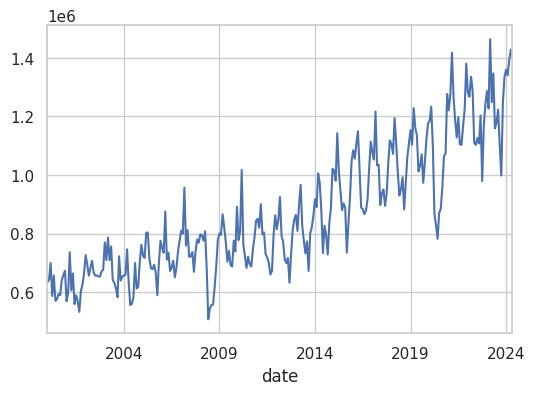

In [44]:
diesel_consumption.plot()

#### **(2) Importación de Gasolina Regular**

In [45]:
get_information(regular_importation)

Time Series Analysis:
---------------------
Start Date: 2001-01-01
End Date: 2024-05-01
Frequency: MS


**Observaciones 💡 -->**

> - **Fecha de inicio**: 2001-01-01. Indica que la serie de tiempo comienza el 1 de enero de 2001.
> - **Fecha de finalización**: 2024-05-01. Indica que la serie de tiempo se extiende hasta el 1 de mayo de 2024.
> - **Frecuencia**: MS (Inicio del mes). Significa que los datos se registran al inicio de cada mes.

<Axes: xlabel='date'>

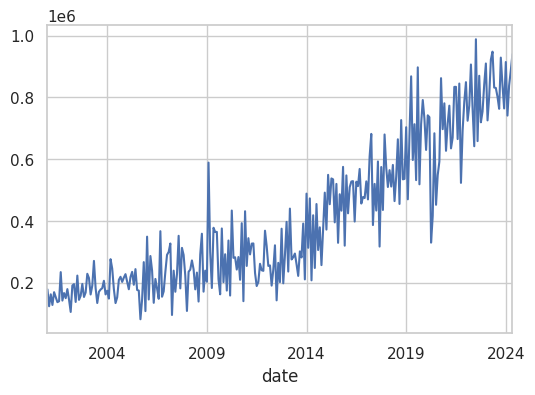

In [46]:
regular_importation.plot()

#### **(3) Precio del Diesel**

In [47]:
get_information(diesel_price)

Time Series Analysis:
---------------------
Start Date: 2021-01-01
End Date: 2024-07-28
Frequency: None


**Observaciones 💡 -->**

> - **Fecha de inicio**: 2021-01-01. Indica que la serie de tiempo comienza el 1 de enero de 2021.
> - **Fecha de finalización**: 2024-07-28. Indica que la serie de tiempo se extiende hasta el 28 de julio de 2024.
> - **Frecuencia**: Ninguna. Significa que no es posible inferir de manera automática la frecuencia de los datos. A pesar de esto, se sabe que se tiene una entrada por día hasta la última fecha registrada.

<Axes: xlabel='date'>

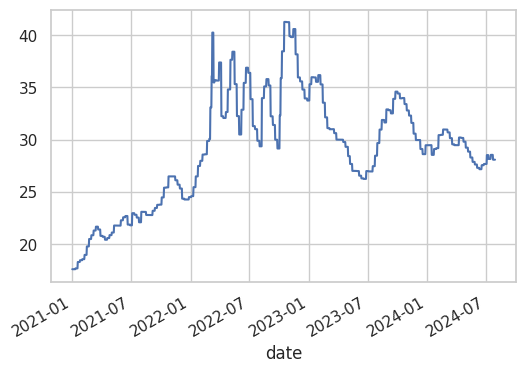

In [48]:
diesel_price.plot()

### **(3) ADF y Transformaciones**

In [50]:
def adf_test(series):
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'  {key}: {value:.3f}')

    if p_value < 0.05:
        print("The series is stationary (reject H0).")
        return True

    else:
        print("The series is non-stationary (fail to reject H0).")
        return False

In [51]:
def find_stationarity(series):
    diff_series = series.copy()
    differencing_order = 0

    while not adf_test(diff_series):
        differencing_order += 1
        diff_series = diff_series.diff().dropna()

    print(f"The series became stationary after {differencing_order} differencings.\n")
    return diff_series

In [52]:
diesel_consumption_diff = find_stationarity(diesel_consumption)
regular_importation_diff = find_stationarity(regular_importation)
diesel_price_diff = find_stationarity(diesel_price)

ADF Statistic: 0.145239821178108
p-value: 0.9690175028779469
Critical Values:
  1%: -3.454
  5%: -2.872
  10%: -2.572
The series is non-stationary (fail to reject H0).
ADF Statistic: -7.094677414843632
p-value: 4.3199961290916e-10
Critical Values:
  1%: -3.454
  5%: -2.872
  10%: -2.572
The series is stationary (reject H0).
The series became stationary after 1 differencings.

ADF Statistic: 0.8288289928204887
p-value: 0.992087554110633
Critical Values:
  1%: -3.455
  5%: -2.872
  10%: -2.572
The series is non-stationary (fail to reject H0).
ADF Statistic: -10.111097641346007
p-value: 9.998584727414137e-18
Critical Values:
  1%: -3.455
  5%: -2.872
  10%: -2.572
The series is stationary (reject H0).
The series became stationary after 1 differencings.

ADF Statistic: -2.3778133545877242
p-value: 0.14809658351111565
Critical Values:
  1%: -3.435
  5%: -2.864
  10%: -2.568
The series is non-stationary (fail to reject H0).
ADF Statistic: -7.090525705456001
p-value: 4.4224777713129156e-10
Cr

### **(4) Modelos LSTM**